# Machine Learning - Laboratory 4

In [28]:
import numpy as np
import pickle
import pandas as pd
from pdffuns import *
import matplotlib.pyplot as plt

## Problem 1

### Section a)

In [29]:
# Load the data
pfile = 'lab4.p'

with open(pfile, "rb") as fp:
    X, Y = pickle.load(fp)

for x in X:
    npX = np.array(x)
    print(f"X.shape = {npX.shape}")
    
for y in Y:
    npY = np.array(y)
    print(f"Y.shape = {npY.shape}")
    

X.shape = (2, 120)
X.shape = (2, 80)
Y.shape = (2, 120)
Y.shape = (2, 80)


### Section b)

The classifier is already designed in a parametrized way, so we will be able to use it for both problems.

In [30]:
def classify(training_data, input_data, classifier="ML", param = 1, verbose=False):
    """
    Train the model based on the training data

    Parameters
    ----------
    training_data : list
        List of training data points
    input_data : list
        List of input data points
    classifier : str
        Classifier to use. Options are:
            - "ML" : Maximum likelihood
            - "PZ" : Parzen window
            - "knn" : k-nearest neighbor
    param : int
        Parameter for the classifier. For knn this is the number of neighbors
    verbose : bool
        If True, print some information of the dataset that is being used

    """

    # LEARN THE PARAMETERS FROM THE TRAINING DATA
    # Get the number of classes and the number of dimensions
    M = len(training_data)
    l = len(training_data[0])

    # Append both number of samples in the same array
    N = []
    for i in range(M):
        N.append(len(training_data[i][0]))

    if verbose:
        print(f"M = {M}")
        print(f"l = {l}")
        for i in range(M):
            print(f"samples_w{i+1} = {N[i]}")

    # Determine prior probabilities
    Pw = []

    for i in range(M):
        Pw.append(N[i]/sum(N))

    # Initialize the parameters
    my = np.zeros(shape=(M, l), dtype=float)
    Sgm = np.zeros(shape=(M, l, l), dtype=float)

    # Initialize the probability density function and the discriminant function
    pxw = np.zeros(shape=(M, np.shape(input_data)[1]))
    g = np.zeros(shape=pxw.shape)                       # Discriminant function values for both classes
    g_max = np.zeros(shape=(np.shape(input_data)[1]))   # Array of maximun g value for each sample
    C = np.zeros(shape=(np.shape(input_data)[1]))       # Array of classification labels
    p = 0

    for i in range(M):
        if classifier == "ML":
            # Estimate parameters my[k], Sgm[k]
            for j in range(l):
                my[i][j] = np.mean(training_data[i][j])

            Sgm[i] = np.cov(training_data[i])

            # Compute the probability density function of the input data using the learnt parameters from the training data
            pxw[i] = norm2D_samples(my[i].reshape(-1, 1), Sgm[i], input_data)
            
        if classifier == "PZ":
            h1 = param
            hn = h1/np.sqrt(N[i])
            hnI = hn**2 * np.eye(l)
          
            # iterate over all feature vectors in class i 
            for j in range(0, N[i]):
                # feature vector j of class i 
                xk = training_data[i][:,j].reshape(l,1)
                # sum up the probabilities of each of the N[i] distributions
                # Note that there is one distribution for each datapoint!
                pxw[i] = pxw[i] + norm2D_samples(xk, hnI, input_data)
                # divide by number of feature vectors in class i 
            pxw[i] = 1 / N[i] * pxw[i]
            
        if classifier == "knn":
            pxw[i] = knn2D(training_data[i], input_data, param)
    
    # - update p
    p += Pw[i] * pxw[i]

    # Determine discriminant functions, g[k], k = 0,...,M-1
    for i in range(M):
        g[i] = (Pw[i] * pxw[i])

    # Divide by the total probability to get the posterior probabilities
    g = g/p

    # Once computed the discriminant function values, we need to check what class has te maximun value on each
    for i in range(np.shape(g)[1]):
        C[i] = np.argmax(g[:, i])
    
    g_max = np.max(g, axis=0)
        
    return g_max, C

In [31]:
def computeMetrics(C, Y):
    """
    Compute the metrics given the classification labels and the true labels

    Parameters
    ----------
    C : array-like
        Classification labels
    Y : array-like
        True labels
    """

    M = len(Y)
    n_samples = []
    
    for i in range(M):
        n_samples.append(len(Y[i]))

    # Initialization of the metrics
    accuracy = []
    error = 0

    # Compute for each class
    for i in range(M):
        # Compute the accuracy
        acc_value = (np.sum(C[i] == Y[i])/n_samples[i])
        accuracy.append(acc_value)

        # Compute the number of misclassified samples
        error += np.sum(C[i] != Y[i])
        
    # Divide the number of missclassified samples by the total number of samples to get the error
    error /= sum(n_samples)

    return accuracy, error

In [32]:
M = len(Y)

# Create the ground truth labels
ground_truth_w1 = np.zeros(shape=(120), dtype=int)
ground_truth_w2 = np.ones(shape=(80), dtype=int)
ground_truth = [ground_truth_w1, ground_truth_w2]

gx = np.full(shape=(M), fill_value=np.array)
Cx = np.full(shape=(M), fill_value=np.array)

gy = np.full(shape=(M), fill_value=np.array)
Cy = np.full(shape=(M), fill_value=np.array)

#ML
for k in range(0, M):
    gx[k], Cx[k] = classify(Y, X[k], verbose=False)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y, Y[k], verbose=False)

accuracy_test, error_test = computeMetrics(Cx, ground_truth)
accuracy_recl, error_recl = computeMetrics(Cy, ground_truth)

#Parzen = 0.1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y, X[k], verbose=False, classifier="PZ", param=0.1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y, Y[k], verbose=False, classifier="PZ", param=0.1)

accuracy_test_pz, error_test_pz = computeMetrics(Cx, ground_truth)
accuracy_recl_pz, error_recl_pz = computeMetrics(Cy, ground_truth)

#Parzen = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y, X[k], verbose=False, classifier="PZ", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y, Y[k], verbose=False, classifier="PZ", param=5)

accuracy_test_pz_5, error_test_pz_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_pz_5, error_recl_pz_5 = computeMetrics(Cy, ground_truth)

#kNN = 1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y, X[k], verbose=False, classifier="knn", param=1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y, Y[k], verbose=False, classifier="knn", param=1)

accuracy_test_knn, error_test_knn = computeMetrics(Cx, ground_truth)
accuracy_recl_knn, error_recl_knn = computeMetrics(Cy, ground_truth)

#kNN = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y, X[k], verbose=False, classifier="knn", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y, Y[k], verbose=False, classifier="knn", param=5)

accuracy_test_knn_5, error_test_knn_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_knn_5, error_recl_knn_5 = computeMetrics(Cy, ground_truth)


C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: divide by zero encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: invalid value encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: overflow encountered in divide
  g = g/p


### Data Frame of the metrics

In [33]:
row_names = [
    'ML reclassification',
    'ML testing',
    'Parzen h1 = 0.1 reclassification',
    'Parzen h1 = 0.1 testing',
    'Parzen h1 = 5 reclassification',
    'Parzen h1 = 5 testing',
    'Nearest neighbor kn = 1 reclassification',
    'Nearest neighbor kn = 1 testing',
    'Nearest neighbor kn = 5 reclassification',
    'Nearest neighbor kn = 5 testing'
]

df = pd.DataFrame(row_names)
df['P(error)'] = [error_recl, error_test, error_recl_pz, error_test_pz, error_recl_pz_5, error_test_pz_5, error_recl_knn, error_test_knn, error_recl_knn_5, error_test_knn_5]
df['P(correct|w1)'] = [accuracy_recl[0], accuracy_test[0], accuracy_recl_pz[0], accuracy_test_pz[0], accuracy_recl_pz_5[0], accuracy_test_pz_5[0], accuracy_recl_knn[0], accuracy_test_knn[0], accuracy_recl_knn_5[0], accuracy_test_knn_5[0]]
df['P(correct|w2)'] = [accuracy_recl[1], accuracy_test[1], accuracy_recl_pz[1], accuracy_test_pz[1], accuracy_recl_pz_5[1], accuracy_test_pz_5[1], accuracy_recl_knn[1], accuracy_test_knn[1], accuracy_recl_knn_5[1], accuracy_test_knn_5[1]]
display(df)

,0,P(error),P(correct|w1),P(correct|w2)
0,ML reclassification,0.100,0.933333,0.8500
1,ML testing,0.045,0.966667,0.9375
2,Parzen h1 = 0.1 reclassification,0.395,0.341667,1.0000
3,Parzen h1 = 0.1 testing,0.565,0.266667,0.6875
4,Parzen h1 = 5 reclassification,0.080,0.925000,0.9125
5,Parzen h1 = 5 testing,0.060,0.950000,0.9250
6,Nearest neighbor kn = 1 reclassification,0.600,0.000000,1.0000
7,Nearest neighbor kn = 1 testing,0.085,0.950000,0.8625
8,Nearest neighbor kn = 5 reclassification,0.090,0.925000,0.8875
9,Nearest neighbor kn = 5 testing,0.075,0.933333,0.9125


# Problem 2

In [34]:
pfile = 'lab4_2.p'
with open(pfile, "rb") as fp:
    X_2D3cl, X_2D4cl, X_2D4cl_ms, X_2D4cl_hs, \
    X_3D3cl_ms, Y_2D3cl, Y_2D4cl, Y_2D4cl_ms, \
    Y_2D4cl_hs, Y_3D3cl_ms = pickle.load(fp)

for x in X_2D3cl:
    npX = np.array(x)
    print(f"X.shape = {npX.shape}")
    
for y in Y_2D3cl:
    npY = np.array(y)
    print(f"Y.shape = {npY.shape}")
   

X.shape = (2, 25)
X.shape = (2, 50)
X.shape = (2, 30)
Y.shape = (2, 25)
Y.shape = (2, 50)
Y.shape = (2, 30)


## Section a)

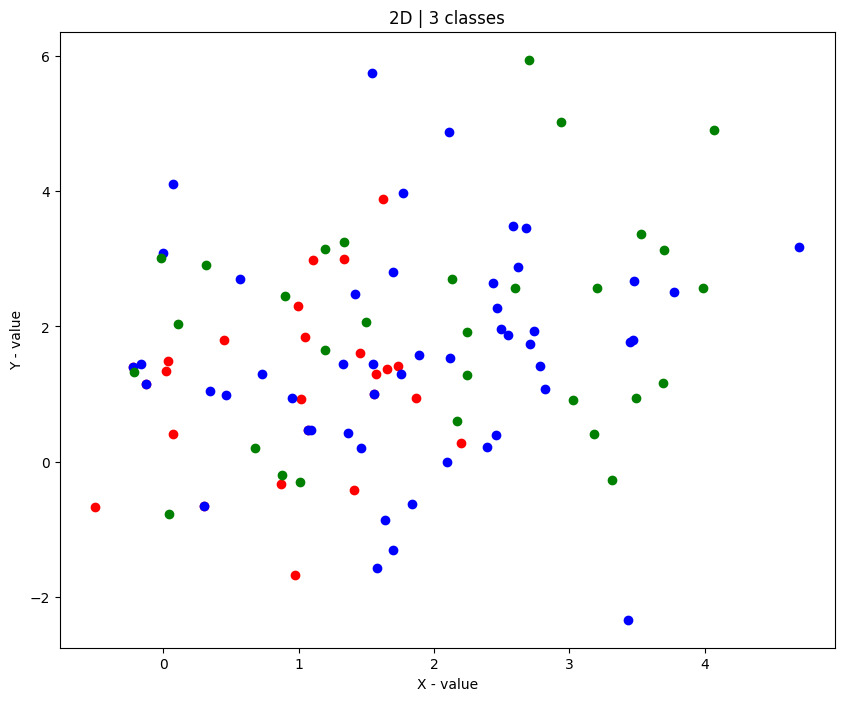

In [35]:
# PLOT THE DATA

M = len(X_2D3cl)
colors = ['red', 'blue', 'green']

for i in range(M):
    plt.scatter(X_2D3cl[i][0], X_2D3cl[i][1], label=f'Class {i+1}', color=colors[i])

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('2D | 3 classes')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

In [36]:
# CLASSIFY THE DATA

# Create the ground truth labels
ground_truth = []
for i in range(M):
    class_ground_truth = np.zeros(shape=(len(X_2D3cl[i][0])), dtype=int)
    class_ground_truth = class_ground_truth + i
    ground_truth.append(class_ground_truth)

gx = np.full(shape=(M), fill_value=np.array)
Cx = np.full(shape=(M), fill_value=np.array)
gy = np.full(shape=(M), fill_value=np.array)
Cy = np.full(shape=(M), fill_value=np.array)

#ML
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D3cl, X_2D3cl[k], verbose=False)
    gy[k], Cy[k] = classify(Y_2D3cl, Y_2D3cl[k], verbose=False)

accuracy_test, error_test = computeMetrics(Cx, ground_truth)
accuracy_recl, error_recl = computeMetrics(Cy, ground_truth)

#Parzen = 0.1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D3cl, X_2D3cl[k], verbose=False, classifier="PZ", param=0.1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D3cl, Y_2D3cl[k], verbose=False, classifier="PZ", param=0.1)

accuracy_test_pz, error_test_pz = computeMetrics(Cx, ground_truth)
accuracy_recl_pz, error_recl_pz = computeMetrics(Cy, ground_truth)

#Parzen = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D3cl, X_2D3cl[k], verbose=False, classifier="PZ", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D3cl, Y_2D3cl[k], verbose=False, classifier="PZ", param=5)

accuracy_test_pz_5, error_test_pz_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_pz_5, error_recl_pz_5 = computeMetrics(Cy, ground_truth)

#kNN = 1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D3cl, X_2D3cl[k], verbose=False, classifier="knn", param=1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D3cl, Y_2D3cl[k], verbose=False, classifier="knn", param=1)

accuracy_test_knn, error_test_knn = computeMetrics(Cx, ground_truth)
accuracy_recl_knn, error_recl_knn = computeMetrics(Cy, ground_truth)

#kNN = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D3cl, X_2D3cl[k], verbose=False, classifier="knn", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D3cl, Y_2D3cl[k], verbose=False, classifier="knn", param=5)

accuracy_test_knn_5, error_test_knn_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_knn_5, error_recl_knn_5 = computeMetrics(Cy, ground_truth)

C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: divide by zero encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: invalid value encountered in divide
  g = g/p


In [37]:
# DATAFRAME WITH THE RESULTS

row_names = [
    'ML reclassification',
    'ML testing',
    'Parzen h1 = 0.1 reclassification',
    'Parzen h1 = 0.1 testing',
    'Parzen h1 = 5 reclassification',
    'Parzen h1 = 5 testing',
    'Nearest neighbor kn = 1 reclassification',
    'Nearest neighbor kn = 1 testing',
    'Nearest neighbor kn = 5 reclassification',
    'Nearest neighbor kn = 5 testing'
]

df = pd.DataFrame(row_names)
df['P(error)'] = [error_recl, error_test, error_recl_pz, error_test_pz, error_recl_pz_5, error_test_pz_5, error_recl_knn, error_test_knn, error_recl_knn_5, error_test_knn_5]
for i in range(M):
    df[f'P(correct|w{i+1})'] = [accuracy_recl[i], accuracy_test[i], accuracy_recl_pz[i], accuracy_test_pz[i], accuracy_recl_pz_5[i], accuracy_test_pz_5[i], accuracy_recl_knn[i], accuracy_test_knn[i], accuracy_recl_knn_5[i], accuracy_test_knn_5[i]]
    
display(df)

,0,P(error),P(correct|w1),P(correct|w2),P(correct|w3)
0,ML reclassification,0.466667,0.32,0.86,0.166667
1,ML testing,0.533333,0.24,0.78,0.133333
2,Parzen h1 = 0.1 reclassification,0.209524,0.48,0.82,1.000000
3,Parzen h1 = 0.1 testing,0.638095,0.44,0.22,0.533333
4,Parzen h1 = 5 reclassification,0.457143,0.16,0.96,0.166667
5,Parzen h1 = 5 testing,0.533333,0.16,0.82,0.133333
6,Nearest neighbor kn = 1 reclassification,0.714286,0.00,0.00,1.000000
7,Nearest neighbor kn = 1 testing,0.657143,0.32,0.38,0.300000
8,Nearest neighbor kn = 5 reclassification,0.523810,0.36,0.74,0.133333
9,Nearest neighbor kn = 5 testing,0.552381,0.36,0.64,0.200000


## Section b)

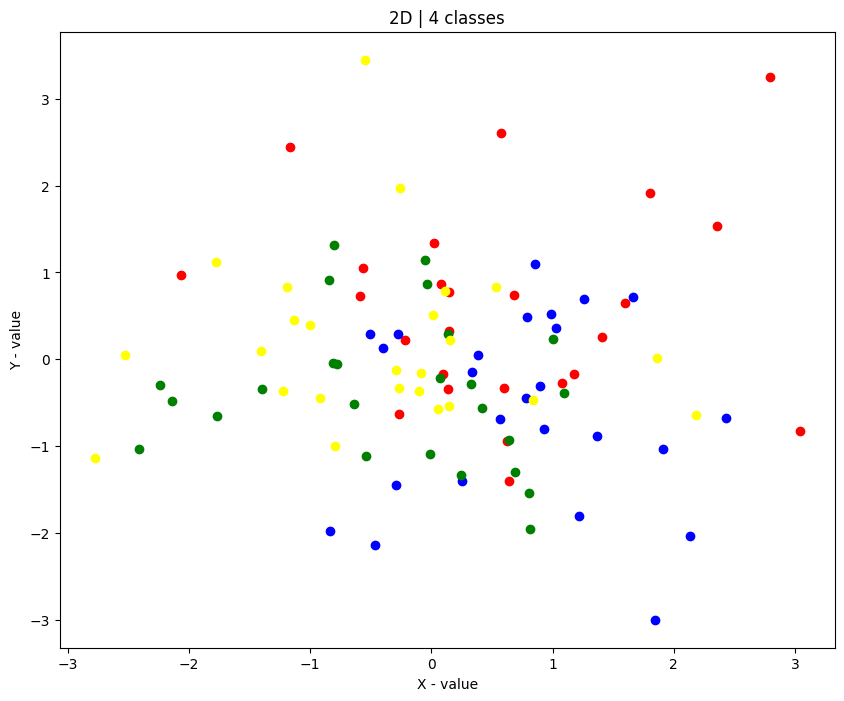

In [38]:
# PLOT THE DATA

M = len(X_2D4cl)
colors = ['red', 'blue', 'green', 'yellow']

for i in range(M):
    plt.scatter(X_2D4cl[i][0], X_2D4cl[i][1], label=f'Class {i+1}', color=colors[i])

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('2D | 4 classes')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

In [39]:
# CLASSIFY THE DATA

# Create the ground truth labels
ground_truth = []
for i in range(M):
    class_ground_truth = np.zeros(shape=(len(X_2D4cl[i][0])), dtype=int)
    class_ground_truth = class_ground_truth + i
    ground_truth.append(class_ground_truth)

gx = np.full(shape=(M), fill_value=np.array)
Cx = np.full(shape=(M), fill_value=np.array)
gy = np.full(shape=(M), fill_value=np.array)
Cy = np.full(shape=(M), fill_value=np.array)

#ML
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl, X_2D4cl[k], verbose=False)
    gy[k], Cy[k] = classify(Y_2D4cl, Y_2D4cl[k], verbose=False)

accuracy_test, error_test = computeMetrics(Cx, ground_truth)
accuracy_recl, error_recl = computeMetrics(Cy, ground_truth)

#Parzen = 0.1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl, X_2D4cl[k], verbose=False, classifier="PZ", param=0.1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl, Y_2D4cl[k], verbose=False, classifier="PZ", param=0.1)

accuracy_test_pz, error_test_pz = computeMetrics(Cx, ground_truth)
accuracy_recl_pz, error_recl_pz = computeMetrics(Cy, ground_truth)

#Parzen = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl, X_2D4cl[k], verbose=False, classifier="PZ", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl, Y_2D4cl[k], verbose=False, classifier="PZ", param=5)

accuracy_test_pz_5, error_test_pz_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_pz_5, error_recl_pz_5 = computeMetrics(Cy, ground_truth)

#kNN = 1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl, X_2D4cl[k], verbose=False, classifier="knn", param=1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl, Y_2D4cl[k], verbose=False, classifier="knn", param=1)

accuracy_test_knn, error_test_knn = computeMetrics(Cx, ground_truth)
accuracy_recl_knn, error_recl_knn = computeMetrics(Cy, ground_truth)

#kNN = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl, X_2D4cl[k], verbose=False, classifier="knn", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl, Y_2D4cl[k], verbose=False, classifier="knn", param=5)

accuracy_test_knn_5, error_test_knn_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_knn_5, error_recl_knn_5 = computeMetrics(Cy, ground_truth)

C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: divide by zero encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: invalid value encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: overflow encountered in divide
  g = g/p


In [40]:
# DATAFRAME WITH THE RESULTS

row_names = [
    'ML reclassification',
    'ML testing',
    'Parzen h1 = 0.1 reclassification',
    'Parzen h1 = 0.1 testing',
    'Parzen h1 = 5 reclassification',
    'Parzen h1 = 5 testing',
    'Nearest neighbor kn = 1 reclassification',
    'Nearest neighbor kn = 1 testing',
    'Nearest neighbor kn = 5 reclassification',
    'Nearest neighbor kn = 5 testing'
]

df = pd.DataFrame(row_names)
df['P(error)'] = [error_recl, error_test, error_recl_pz, error_test_pz, error_recl_pz_5, error_test_pz_5, error_recl_knn, error_test_knn, error_recl_knn_5, error_test_knn_5]
for i in range(M):
    df[f'P(correct|w{i+1})'] = [accuracy_recl[i], accuracy_test[i], accuracy_recl_pz[i], accuracy_test_pz[i], accuracy_recl_pz_5[i], accuracy_test_pz_5[i], accuracy_recl_knn[i], accuracy_test_knn[i], accuracy_recl_knn_5[i], accuracy_test_knn_5[i]]
    
display(df)

,0,P(error),P(correct|w1),P(correct|w2),P(correct|w3),P(correct|w4)
0,ML reclassification,0.48,0.52,0.56,0.44,0.56
1,ML testing,0.63,0.28,0.52,0.28,0.40
2,Parzen h1 = 0.1 reclassification,0.16,0.80,0.80,0.76,1.00
3,Parzen h1 = 0.1 testing,0.71,0.32,0.32,0.12,0.40
4,Parzen h1 = 5 reclassification,0.46,0.52,0.64,0.48,0.52
5,Parzen h1 = 5 testing,0.62,0.24,0.52,0.36,0.40
6,Nearest neighbor kn = 1 reclassification,0.75,0.00,0.00,0.00,1.00
7,Nearest neighbor kn = 1 testing,0.69,0.32,0.48,0.12,0.32
8,Nearest neighbor kn = 5 reclassification,0.53,0.44,0.48,0.52,0.44
9,Nearest neighbor kn = 5 testing,0.61,0.24,0.52,0.40,0.40


## Section c)

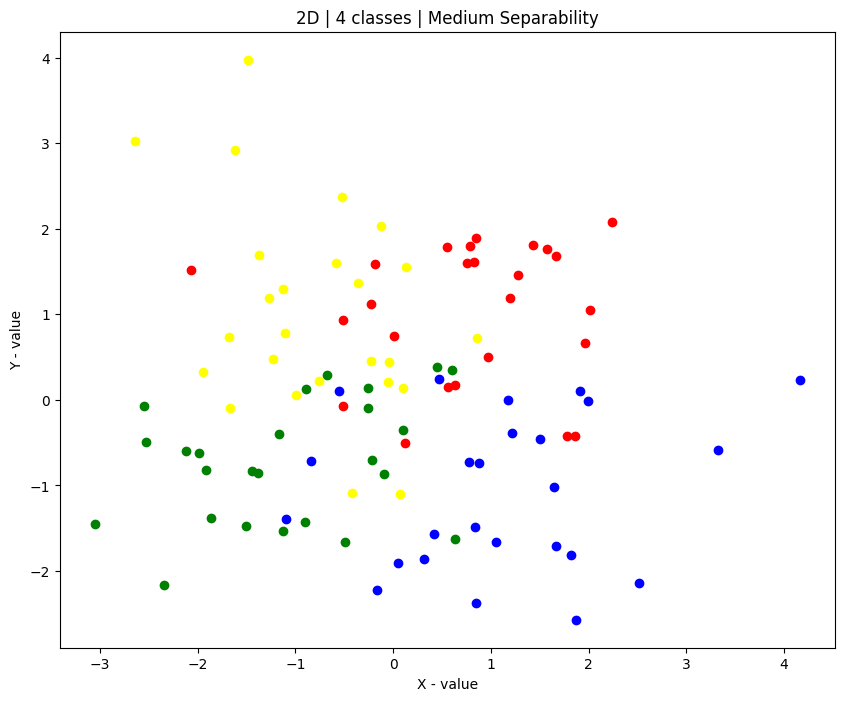

In [41]:
M = len(X_2D4cl_ms)
colors = ['red', 'blue', 'green', 'yellow']

for i in range(M):
    plt.scatter(X_2D4cl_ms[i][0], X_2D4cl_ms[i][1], label=f'Class {i+1}', color=colors[i])

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('2D | 4 classes | Medium Separability')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

In [42]:
# CLASSIFY THE DATA

# Create the ground truth labels
ground_truth = []
for i in range(M):
    class_ground_truth = np.zeros(shape=(len(X_2D4cl_ms[i][0])), dtype=int)
    class_ground_truth = class_ground_truth + i
    ground_truth.append(class_ground_truth)

gx = np.full(shape=(M), fill_value=np.array)
Cx = np.full(shape=(M), fill_value=np.array)
gy = np.full(shape=(M), fill_value=np.array)
Cy = np.full(shape=(M), fill_value=np.array)

#ML
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_ms, X_2D4cl_ms[k], verbose=False)
    gy[k], Cy[k] = classify(Y_2D4cl_ms, Y_2D4cl_ms[k], verbose=False)

accuracy_test, error_test = computeMetrics(Cx, ground_truth)
accuracy_recl, error_recl = computeMetrics(Cy, ground_truth)

#Parzen = 0.1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_ms, X_2D4cl_ms[k], verbose=False, classifier="PZ", param=0.1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_ms, Y_2D4cl_ms[k], verbose=False, classifier="PZ", param=0.1)

accuracy_test_pz, error_test_pz = computeMetrics(Cx, ground_truth)
accuracy_recl_pz, error_recl_pz = computeMetrics(Cy, ground_truth)

#Parzen = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_ms, X_2D4cl_ms[k], verbose=False, classifier="PZ", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_ms, Y_2D4cl_ms[k], verbose=False, classifier="PZ", param=5)

accuracy_test_pz_5, error_test_pz_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_pz_5, error_recl_pz_5 = computeMetrics(Cy, ground_truth)

#kNN = 1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_ms, X_2D4cl_ms[k], verbose=False, classifier="knn", param=1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_ms, Y_2D4cl_ms[k], verbose=False, classifier="knn", param=1)

accuracy_test_knn, error_test_knn = computeMetrics(Cx, ground_truth)
accuracy_recl_knn, error_recl_knn = computeMetrics(Cy, ground_truth)

#kNN = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_ms, X_2D4cl_ms[k], verbose=False, classifier="knn", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_ms, Y_2D4cl_ms[k], verbose=False, classifier="knn", param=5)

accuracy_test_knn_5, error_test_knn_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_knn_5, error_recl_knn_5 = computeMetrics(Cy, ground_truth)

C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: divide by zero encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: invalid value encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: overflow encountered in divide
  g = g/p


In [43]:
# DATAFRAME WITH THE RESULTS

row_names = [
    'ML reclassification',
    'ML testing',
    'Parzen h1 = 0.1 reclassification',
    'Parzen h1 = 0.1 testing',
    'Parzen h1 = 5 reclassification',
    'Parzen h1 = 5 testing',
    'Nearest neighbor kn = 1 reclassification',
    'Nearest neighbor kn = 1 testing',
    'Nearest neighbor kn = 5 reclassification',
    'Nearest neighbor kn = 5 testing'
]

df = pd.DataFrame(row_names)
df['P(error)'] = [error_recl, error_test, error_recl_pz, error_test_pz, error_recl_pz_5, error_test_pz_5, error_recl_knn, error_test_knn, error_recl_knn_5, error_test_knn_5]
for i in range(M):
    df[f'P(correct|w{i+1})'] = [accuracy_recl[i], accuracy_test[i], accuracy_recl_pz[i], accuracy_test_pz[i], accuracy_recl_pz_5[i], accuracy_test_pz_5[i], accuracy_recl_knn[i], accuracy_test_knn[i], accuracy_recl_knn_5[i], accuracy_test_knn_5[i]]
    
display(df)

,0,P(error),P(correct|w1),P(correct|w2),P(correct|w3),P(correct|w4)
0,ML reclassification,0.29,0.72,0.72,0.68,0.72
1,ML testing,0.29,0.64,0.64,0.76,0.80
2,Parzen h1 = 0.1 reclassification,0.40,0.68,0.28,0.44,1.00
3,Parzen h1 = 0.1 testing,0.59,0.56,0.04,0.28,0.76
4,Parzen h1 = 5 reclassification,0.28,0.80,0.68,0.68,0.72
5,Parzen h1 = 5 testing,0.28,0.76,0.64,0.72,0.76
6,Nearest neighbor kn = 1 reclassification,0.75,0.00,0.00,0.00,1.00
7,Nearest neighbor kn = 1 testing,0.42,0.60,0.48,0.52,0.72
8,Nearest neighbor kn = 5 reclassification,0.31,0.76,0.68,0.60,0.72
9,Nearest neighbor kn = 5 testing,0.30,0.72,0.60,0.68,0.80


## Section d)

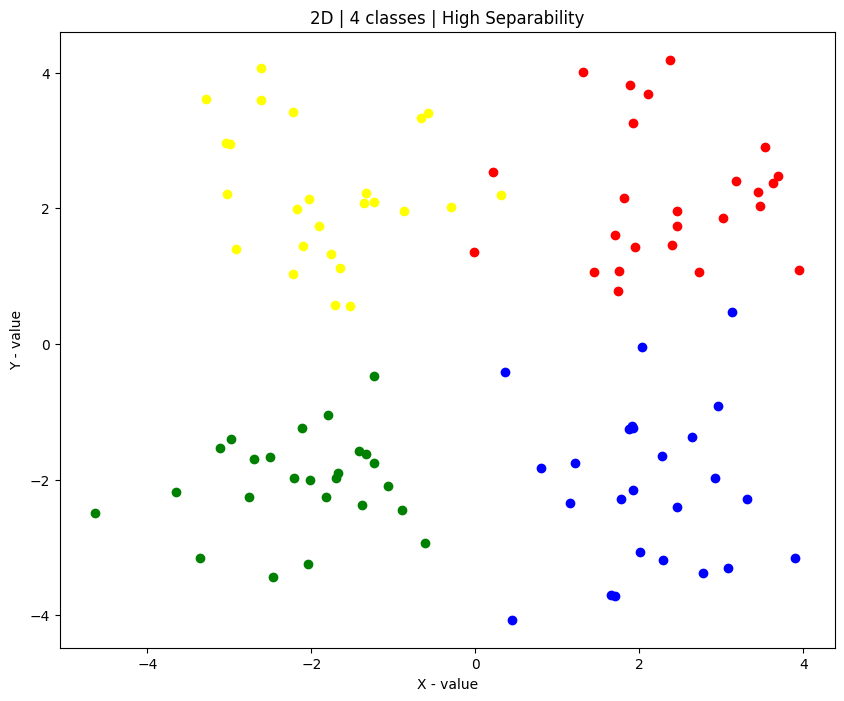

In [44]:
M = len(X_2D4cl_hs)
colors = ['red', 'blue', 'green', 'yellow']

for i in range(M):
    plt.scatter(X_2D4cl_hs[i][0], X_2D4cl_hs[i][1], label=f'Class {i+1}', color=colors[i])

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('2D | 4 classes | High Separability')
plt.xlabel('X - value')
plt.ylabel('Y - value')
plt.show()

In [45]:
# CLASSIFY THE DATA

# Create the ground truth labels
ground_truth = []
for i in range(M):
    class_ground_truth = np.zeros(shape=(len(X_2D4cl_hs[i][0])), dtype=int)
    class_ground_truth = class_ground_truth + i
    ground_truth.append(class_ground_truth)

gx = np.full(shape=(M), fill_value=np.array)
Cx = np.full(shape=(M), fill_value=np.array)
gy = np.full(shape=(M), fill_value=np.array)
Cy = np.full(shape=(M), fill_value=np.array)

#ML
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_hs, X_2D4cl_hs[k], verbose=False)
    gy[k], Cy[k] = classify(Y_2D4cl_hs, Y_2D4cl_hs[k], verbose=False)

accuracy_test, error_test = computeMetrics(Cx, ground_truth)
accuracy_recl, error_recl = computeMetrics(Cy, ground_truth)

#Parzen = 0.1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_hs, X_2D4cl_hs[k], verbose=False, classifier="PZ", param=0.1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_hs, Y_2D4cl_hs[k], verbose=False, classifier="PZ", param=0.1)

accuracy_test_pz, error_test_pz = computeMetrics(Cx, ground_truth)
accuracy_recl_pz, error_recl_pz = computeMetrics(Cy, ground_truth)

#Parzen = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_hs, X_2D4cl_hs[k], verbose=False, classifier="PZ", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_hs, Y_2D4cl_hs[k], verbose=False, classifier="PZ", param=5)

accuracy_test_pz_5, error_test_pz_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_pz_5, error_recl_pz_5 = computeMetrics(Cy, ground_truth)

#kNN = 1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_hs, X_2D4cl_hs[k], verbose=False, classifier="knn", param=1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_hs, Y_2D4cl_hs[k], verbose=False, classifier="knn", param=1)

accuracy_test_knn, error_test_knn = computeMetrics(Cx, ground_truth)
accuracy_recl_knn, error_recl_knn = computeMetrics(Cy, ground_truth)

#kNN = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_2D4cl_hs, X_2D4cl_hs[k], verbose=False, classifier="knn", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_2D4cl_hs, Y_2D4cl_hs[k], verbose=False, classifier="knn", param=5)

accuracy_test_knn_5, error_test_knn_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_knn_5, error_recl_knn_5 = computeMetrics(Cy, ground_truth)

C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: divide by zero encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: invalid value encountered in divide
  g = g/p


In [46]:
# DATAFRAME WITH THE RESULTS

row_names = [
    'ML reclassification',
    'ML testing',
    'Parzen h1 = 0.1 reclassification',
    'Parzen h1 = 0.1 testing',
    'Parzen h1 = 5 reclassification',
    'Parzen h1 = 5 testing',
    'Nearest neighbor kn = 1 reclassification',
    'Nearest neighbor kn = 1 testing',
    'Nearest neighbor kn = 5 reclassification',
    'Nearest neighbor kn = 5 testing'
]

df = pd.DataFrame(row_names)
df['P(error)'] = [error_recl, error_test, error_recl_pz, error_test_pz, error_recl_pz_5, error_test_pz_5, error_recl_knn, error_test_knn, error_recl_knn_5, error_test_knn_5]
for i in range(M):
    df[f'P(correct|w{i+1})'] = [accuracy_recl[i], accuracy_test[i], accuracy_recl_pz[i], accuracy_test_pz[i], accuracy_recl_pz_5[i], accuracy_test_pz_5[i], accuracy_recl_knn[i], accuracy_test_knn[i], accuracy_recl_knn_5[i], accuracy_test_knn_5[i]]
    
display(df)

,0,P(error),P(correct|w1),P(correct|w2),P(correct|w3),P(correct|w4)
0,ML reclassification,0.07,0.92,0.88,0.96,0.96
1,ML testing,0.05,0.96,0.88,1.00,0.96
2,Parzen h1 = 0.1 reclassification,0.72,0.04,0.00,0.08,1.00
3,Parzen h1 = 0.1 testing,0.76,0.00,0.04,0.00,0.92
4,Parzen h1 = 5 reclassification,0.05,0.96,0.92,0.96,0.96
5,Parzen h1 = 5 testing,0.05,0.96,0.88,1.00,0.96
6,Nearest neighbor kn = 1 reclassification,0.75,0.00,0.00,0.00,1.00
7,Nearest neighbor kn = 1 testing,0.08,0.88,0.88,0.96,0.96
8,Nearest neighbor kn = 5 reclassification,0.08,0.88,0.92,0.96,0.92
9,Nearest neighbor kn = 5 testing,0.04,0.92,0.92,1.00,1.00


We can easily notice that the more splitted is the data, the easier is for the classifier to classify it.

## Section e)

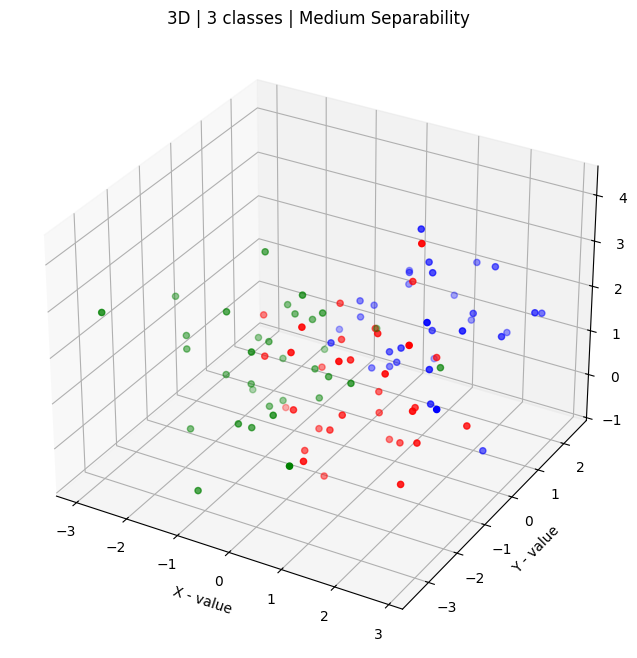

In [47]:
M = len(X_3D3cl_ms)
colors = ['red', 'blue', 'green']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(M):
    ax.scatter(X_3D3cl_ms[i][0], X_3D3cl_ms[i][1], X_3D3cl_ms[i][2], label=f'Class {i+1}', color=colors[i])

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.title('3D | 3 classes | Medium Separability')
ax.set_xlabel('X - value')
ax.set_ylabel('Y - value')
ax.set_zlabel('Z - value')
plt.show()

In [48]:
# CLASSIFY THE DATA

# Create the ground truth labels
ground_truth = []
for i in range(M):
    class_ground_truth = np.zeros(shape=(len(X_3D3cl_ms[i][0])), dtype=int)
    class_ground_truth = class_ground_truth + i
    ground_truth.append(class_ground_truth)

gx = np.full(shape=(M), fill_value=np.array)
Cx = np.full(shape=(M), fill_value=np.array)
gy = np.full(shape=(M), fill_value=np.array)
Cy = np.full(shape=(M), fill_value=np.array)

#ML
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_3D3cl_ms, X_3D3cl_ms[k], verbose=False)
    gy[k], Cy[k] = classify(Y_3D3cl_ms, Y_3D3cl_ms[k], verbose=False)

accuracy_test, error_test = computeMetrics(Cx, ground_truth)
accuracy_recl, error_recl = computeMetrics(Cy, ground_truth)

#Parzen = 0.1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_3D3cl_ms, X_3D3cl_ms[k], verbose=False, classifier="PZ", param=0.1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_3D3cl_ms, Y_3D3cl_ms[k], verbose=False, classifier="PZ", param=0.1)

accuracy_test_pz, error_test_pz = computeMetrics(Cx, ground_truth)
accuracy_recl_pz, error_recl_pz = computeMetrics(Cy, ground_truth)

#Parzen = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_3D3cl_ms, X_3D3cl_ms[k], verbose=False, classifier="PZ", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_3D3cl_ms, Y_3D3cl_ms[k], verbose=False, classifier="PZ", param=5)

accuracy_test_pz_5, error_test_pz_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_pz_5, error_recl_pz_5 = computeMetrics(Cy, ground_truth)

#kNN = 1
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_3D3cl_ms, X_3D3cl_ms[k], verbose=False, classifier="knn", param=1)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_3D3cl_ms, Y_3D3cl_ms[k], verbose=False, classifier="knn", param=1)

accuracy_test_knn, error_test_knn = computeMetrics(Cx, ground_truth)
accuracy_recl_knn, error_recl_knn = computeMetrics(Cy, ground_truth)

#kNN = 5
for k in range(0, M):
    gx[k], Cx[k] = classify(Y_3D3cl_ms, X_3D3cl_ms[k], verbose=False, classifier="knn", param=5)
for k in range(0, M):
    gy[k], Cy[k] = classify(Y_3D3cl_ms, Y_3D3cl_ms[k], verbose=False, classifier="knn", param=5)

accuracy_test_knn_5, error_test_knn_5 = computeMetrics(Cx, ground_truth)
accuracy_recl_knn_5, error_recl_knn_5 = computeMetrics(Cy, ground_truth)

C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: divide by zero encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: invalid value encountered in divide
  g = g/p
C:\Users\danie\AppData\Local\Temp\ipykernel_2912\3549508331.py:93: RuntimeWarning: overflow encountered in divide
  g = g/p


In [49]:
# DATAFRAME WITH THE RESULTS

row_names = [
    'ML reclassification',
    'ML testing',
    'Parzen h1 = 0.1 reclassification',
    'Parzen h1 = 0.1 testing',
    'Parzen h1 = 5 reclassification',
    'Parzen h1 = 5 testing',
    'Nearest neighbor kn = 1 reclassification',
    'Nearest neighbor kn = 1 testing',
    'Nearest neighbor kn = 5 reclassification',
    'Nearest neighbor kn = 5 testing'
]

df = pd.DataFrame(row_names)
df['P(error)'] = [error_recl, error_test, error_recl_pz, error_test_pz, error_recl_pz_5, error_test_pz_5, error_recl_knn, error_test_knn, error_recl_knn_5, error_test_knn_5]
for i in range(M):
    df[f'P(correct|w{i+1})'] = [accuracy_recl[i], accuracy_test[i], accuracy_recl_pz[i], accuracy_test_pz[i], accuracy_recl_pz_5[i], accuracy_test_pz_5[i], accuracy_recl_knn[i], accuracy_test_knn[i], accuracy_recl_knn_5[i], accuracy_test_knn_5[i]]
    
display(df)

,0,P(error),P(correct|w1),P(correct|w2),P(correct|w3)
0,ML reclassification,0.212121,0.666667,0.848485,0.848485
1,ML testing,0.171717,0.909091,0.848485,0.727273
2,Parzen h1 = 0.1 reclassification,0.545455,0.181818,0.181818,1.000000
3,Parzen h1 = 0.1 testing,0.666667,0.363636,0.212121,0.424242
4,Parzen h1 = 5 reclassification,0.171717,0.757576,0.818182,0.909091
5,Parzen h1 = 5 testing,0.202020,0.848485,0.818182,0.727273
6,Nearest neighbor kn = 1 reclassification,0.666667,0.000000,0.000000,1.000000
7,Nearest neighbor kn = 1 testing,0.333333,0.818182,0.545455,0.636364
8,Nearest neighbor kn = 5 reclassification,0.212121,0.666667,0.787879,0.909091
9,Nearest neighbor kn = 5 testing,0.212121,0.848485,0.818182,0.696970


### Authors

Daniel Linfon Ye Liu

Antón Maestre Gómez
